Import 

In [62]:
import cv2
import os
import numpy as np              
import import_ipynb
from lsb import extract_lsb, text_to_bits, bits_to_text, psnr

Deklarasi Gaussian Noise

In [ ]:
def add_gaussian_noise(image, mean=0, std=10):
    noise = np.random.normal(mean, std, image.shape)
    noisy_img = image + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

Batch Attack

In [ ]:
def batch_attack_gaussian(input_dir, output_dir, mean=0, std=10):
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = imread(os.path.join(input_dir, fname))
            noisy = add_gaussian_noise(img, mean, std)
            imsave(os.path.join(output_dir, fname), noisy)
    print(f" Noise attack selesai untuk std={std} → folder: {output_dir}")

Uji Robustness

In [ ]:
#Beberapa Standart Deviasi untuk diuji
std_values = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50]
results = []

# Uji Batch Atk dgn std values
for std in std_values:
    print(f"\n>== Uji Gaussian Noise std = {std} ==<")
    
    noisy_dir = f"stego_batik_noisy_{std}"
    batch_attack_gaussian("stego_batik", noisy_dir, mean=0, std=std)
    
    res_noisy = batch_extract("dataset_png", noisy_dir)
    
    success = sum(1 for _, msg, _ in res_noisy if "Batik" in msg)
    psnr_values = [p for _, _, p in res_noisy if p is not None]
    avg_psnr = np.mean(psnr_values) if psnr_values else 0
    
    print(f"Pesan berhasil diekstrak: {success}/{len(res_noisy)} gambar")
    print(f"Rata-rata PSNR: {avg_psnr:.2f} dB")
    
    results.append((std, success, avg_psnr))



>== Uji Gaussian Noise std = 1 ==<
Gaussian noise ditambahkan: stego_1.png
Gaussian noise ditambahkan: stego_10.png
Gaussian noise ditambahkan: stego_11.png
Gaussian noise ditambahkan: stego_12.png
Gaussian noise ditambahkan: stego_13.png
Gaussian noise ditambahkan: stego_14.png
Gaussian noise ditambahkan: stego_15.png
Gaussian noise ditambahkan: stego_16.png
Gaussian noise ditambahkan: stego_17.png
Gaussian noise ditambahkan: stego_18.png
Gaussian noise ditambahkan: stego_19.png
Gaussian noise ditambahkan: stego_2.png
Gaussian noise ditambahkan: stego_20.png
Gaussian noise ditambahkan: stego_21.png
Gaussian noise ditambahkan: stego_22.png
Gaussian noise ditambahkan: stego_23.png
Gaussian noise ditambahkan: stego_24.png
Gaussian noise ditambahkan: stego_25.png
Gaussian noise ditambahkan: stego_26.png
Gaussian noise ditambahkan: stego_27.png
Gaussian noise ditambahkan: stego_28.png
Gaussian noise ditambahkan: stego_29.png
Gaussian noise ditambahkan: stego_3.png
Gaussian noise ditambahk

Hasil ekstraksi

In [ ]:
print("\n===== SUM UJI GAUSSIAN NOISE =====")
print(f"{'STD':<10}{'Berhasil':<15}{'Rata-rata PSNR (dB)':<20}")
for std, succ, psnr_val in results:
    print(f"{std:<10}{succ:<15}{psnr_val:<20.2f}")


===== SUM UJI GAUSSIAN NOISE =====
STD       Berhasil       Rata-rata PSNR (dB) 
1         0              46.99               
3         0              38.58               
5         0              34.36               
10        0              30.48               
15        0              29.39               
20        0              28.89               
25        0              28.60               
30        0              28.42               
40        0              28.21               
50        0              28.11               


Visualisasi Matplot

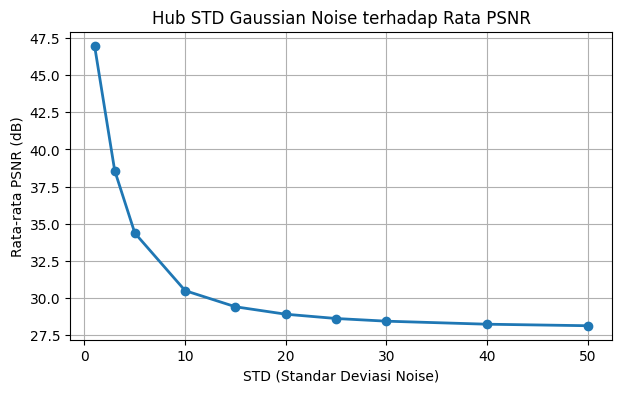

In [70]:
import matplotlib.pyplot as plt

stds = [r[0] for r in results]
psnrs = [r[2] for r in results]

plt.figure(figsize=(7,4))
plt.plot(stds, psnrs, marker='o', linewidth=2)
plt.title("Hub STD Gaussian Noise terhadap Rata PSNR")
plt.xlabel("STD (Standar Deviasi Noise)")
plt.ylabel("Rata-rata PSNR (dB)")
plt.grid(True)
plt.show()